# K-Means with Text Data

In this assignment you will
* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters
* Evaluate clustering, both quantitatively and qualitatively

When properly executed, clustering uncovers valuable insights from a set of unlabeled documents.

## Import Necessary Libraries

In [1]:
import numpy as np                                             
import pandas as pd  
import os
import json
import time
import string
import sys
from scipy.sparse import csr_matrix                            
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from copy import copy
from itertools import combinations
import matplotlib.pyplot as plt                                
%matplotlib inline

## Load data, extract features

In [2]:
wiki = pd.read_csv('people_wiki.csv')

In [3]:
wiki

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...
59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...
59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...
59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...


In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    return csr_matrix( (data, indices, indptr), shape)
        
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [5]:
tf_idf

<59071x547979 sparse matrix of type '<class 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [6]:
wiki

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...
59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...
59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...
59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...


In [7]:
with open('people_wiki_map_index_to_word.json') as people_wiki_map_index_to_word:    
    map_index_to_word = json.load(people_wiki_map_index_to_word)

(Optional) Extracting TF-IDF vectors yourself. We provide the pre-computed TF-IDF vectors to minimize potential compatibility issues. You are free to experiment with other tools to compute the TF-IDF vectors yourself. A good place to start is sklearn.TfidfVectorizer. Note. Due to variations in tokenization and other factors, your TF-IDF vectors may differ from the ones we provide. For the purpose the assessment, we ask you to use the vectors from people_wiki_tf_idf.npz.

*(Optional) Extracting TF-IDF vectors yourself*. We provide the pre-computed TF-IDF vectors to minimize potential compatibility issues. You are free to experiment with other tools to compute the TF-iDF vectors yourself. A good place to start is sklearn.TfidfVectorizer. Note. Due to variations in tokenization and other factors, your TF-IDF vectors may differ from the ones we provide. For the purpose the assessment, we ask you to use the vectors from people_wiki_tf_idf.npz.

In [8]:
def remove_punctuation(text):
    text = text.translate(str.maketrans('','',string.punctuation)) 
    
    return text

wiki['text_clean'] = wiki['text'].apply(remove_punctuation)

In [9]:
vectorizer = TfidfVectorizer()

tf_idf_matrix = vectorizer.fit_transform(wiki['text_clean'])

In [10]:
tf_idf_matrix

<59071x548516 sparse matrix of type '<class 'numpy.float64'>'
	with 10243711 stored elements in Compressed Sparse Row format>

## Normalize all Vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

We use the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [11]:
tf_idf = normalize(tf_idf)

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [12]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In pseudocode, we iteratively do the following:
```
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

### Assigning clusters

How do we implement Step 1 of the main k-means loop above? First import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [13]:
# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print(dist)

[[1.41000789 1.36894636]
 [1.40935215 1.41023886]
 [1.39855967 1.40890299]
 ...
 [1.41108296 1.39123646]
 [1.41022804 1.31468652]
 [1.39899784 1.41072448]]


More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. Write code to compute distances from each of the centroids to all data points in `tf_idf`. Then find the distance between row 430 of `tf_idf` and the second centroid and save it to `dist`.

In [14]:
queries = tf_idf[:3,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')[430][1]

print(dist)

1.4071310658540346


In [15]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as `distances`. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as `closest_cluster`.

**Hint:** the resulting array should be as long as the number of data points.

In [16]:
distances = pairwise_distances(tf_idf, tf_idf[:3,:], metric='euclidean')
closest_cluster = np.argmin(distances, axis=1)

In [17]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Let's put these steps together.  First, initialize three centroids with the first 3 rows of `tf_idf`. Then, compute distances from each of the centroids to all data points in `tf_idf`. Finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment`.

In [18]:
centroids = tf_idf[:3,:]
distances = pairwise_distances(tf_idf, centroids, metric='euclidean')
cluster_assignment = np.argmin(distances, axis=1)

In [19]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


Now we are ready to fill in the blanks in this function:

In [20]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

which is simply generalization of what we did above.

**Checkpoint**. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 2, 4, and 6 of `tf_idf` as an initial set of centroids, we assign cluster labels to rows 0, 10, 20, ..., and 90 of `tf_idf`. The resulting cluster labels should be `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`.

In [21]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing
```
data[cluster_assignment==0,:]
```

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [22]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [23]:
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)

[0 1 0]


The expression "cluster_assignment==1" gives a list of Booleans that says whether each data point is assigned to cluster 1 or not. For cluster 0, the expression is "cluster_assignment==0".

In [24]:
print(cluster_assignment==1)
print(cluster_assignment==0)

[False  True False]
[ True False  True]


In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a True entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [25]:
print(data[cluster_assignment==1])

[[0. 0. 0.]]


The output makes sense since [0 0 0] is closer to [0 -0.5 0] than to [0.5 0.5 0].

Now let's look at the data points assigned to cluster 0:

In [26]:
print(data[cluster_assignment==0])

[[1. 2. 0.]
 [2. 2. 0.]]


Again, this makes sense since these values are each closer to [0.5 0.5 0] than to [0 -0.5 0].

Given all the data points in a cluster, it only remains to compute the mean. Use np.mean(). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the axis argument. See the linked documentation for details.

Use this function to average the data points in cluster 0:

In [27]:
print(data[cluster_assignment==0].mean(axis=0))

[1.5 2.  0. ]


We are now ready to complete this function:

In [28]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = cluster_assignment==i
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = data[cluster_assignment==i].mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

**Checkpoint**. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 90 of `tf_idf` as the data points and the cluster labels `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`, we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [29]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [30]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [31]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [32]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [33]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.show()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

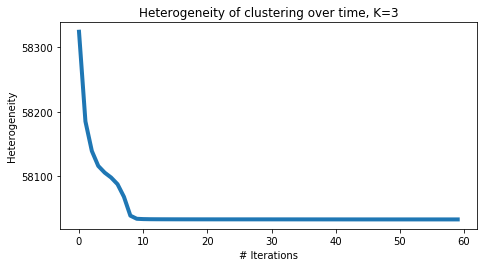





True. The clustering objective (heterogeneity) is non-increasing for this example

Cluster # 2 contains the greatest number of data points


In [34]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)


# The code below is to answer the following quiz questions
print('\n\n==============================================================================\n\n')
heterogeneity_trend = []

for x,y in zip(heterogeneity[::],heterogeneity[1::]) : 
    if x < y :
        heterogeneity_trend.append('Increase')
    elif x > y :
        heterogeneity_trend.append('Decrease')
        
if all(i == 'Increase' for i in heterogeneity_trend) :
    quiz_1_ans = 'False'
else :
    quiz_1_ans = 'True'
    
print(quiz_1_ans + '. The clustering objective (heterogeneity) is non-increasing for this example\n')
cluster_counts = np.bincount(cluster_assignment)


cluster_dict = {'Cluster # 0' : cluster_counts[0], 
                'Cluster # 1' : cluster_counts[1], 
                'Cluster # 2' : cluster_counts[2]}

biggest_cluster = max(cluster_dict)
print(biggest_cluster, 'contains the greatest number of data points')

<font color='steelblue'><b> Quiz 1 : (True/False) The clustering objective (heterogeneity) is non-increasing for this example. </b></font>

<font color='mediumvioletred'><b> Answer 1 : {{quiz_1_ans}} </b></font>

<br/>

<font color='steelblue'><b> Quiz 2 : Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one) </b></font>

<font color='slategray'><b> 
1. k-means algorithm got stuck in a bad local minimum
2. There is a bug in the k-means code
3. All data points consist of exact duplicates
4. Nothing is wrong. The objective should generally go down sooner or later.
</b></font>

<font color='mediumvioletred'><b> Answer 2 : Nothing is wrong. The objective should generally go down sooner or later. </b></font>

<br/>

<font color='steelblue'><b> Quiz 3 : Which of the cluster contains the greatest number of data points in the end? Hint: Use np.bincount() to count occurrences of each cluster label. </b></font>

<font color='slategray'><b> 
1. Cluster # 0
2. Cluster # 1
3. Cluster # 2
</b></font>

<font color='mediumvioletred'><b> Answer 3 : {{biggest_cluster}} contains the greatest number of data points </b></font>

## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take several minutes to run.

In [35]:
k = 10
heterogeneity = {}
cluster_assignment_dict = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)

    # This is the line we added for the next quiz question
    cluster_assignment_dict[seed] = np.bincount(cluster_assignment)
    
#    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    # And this is the modified print statement
    print('seed={0:06d}, heterogeneity={1:.5f}, cluster_distribution={2}'.format(seed, heterogeneity[seed], 
                                           cluster_assignment_dict[seed]))
    sys.stdout.flush()
end = time.time()

print('\n' + str(end-start))


# The code below is to answer the following quiz question
print('\n\n==============================================================================\n\n')

k = 10
heterogeneity = {}
max_values = []
min_values = []
quiz_start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    
    bin_array = np.bincount(cluster_assignment)
    idx = np.argmax(bin_array) 
    val = bin_array[idx]
    print('seed :', seed, '\tmax_idx :', '\tmax_val :', val)
    max_values.append(val)
    
    idx = np.argmin(bin_array) 
    val = bin_array[idx]
    print('seed :', seed, '\tmin_idx :', '\tmin_val :', val)
    min_values.append(val)
    
    # To save time, compute heterogeneity only once in the quiz_end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed :', seed, '\theterogeneity :', heterogeneity[seed])
    print('\n')
    sys.stdout.flush()
    
quiz_end = time.time()
quiz_time = quiz_end - quiz_start

max_value = max(max_values)
min_value = min(min_values)

print('Max Value :', max_value)
print('Min Value :', min_value)

print('\n' + str(quiz_time))

seed=000000, heterogeneity=57457.52442, cluster_distribution=[18047  3824  5671  6983  1492  1730  3882  3449  7139  6854]
seed=020000, heterogeneity=57533.20100, cluster_distribution=[ 3142   768  3566  2277 15779  7278  6146  7964  6666  5485]
seed=040000, heterogeneity=57512.69257, cluster_distribution=[ 5551  6623   186  2999  8487  3893  6807  2921  3472 18132]
seed=060000, heterogeneity=57466.97925, cluster_distribution=[ 3014  3089  6681  3856  8080  7222  3424   424  5381 17900]
seed=080000, heterogeneity=57494.92990, cluster_distribution=[17582  1785  7215  3314  6285   809  5930  6791  5536  3824]
seed=100000, heterogeneity=57484.42210, cluster_distribution=[ 6618  1337  6191  2890 16969  4983  5242  3892  5562  5387]
seed=120000, heterogeneity=57554.62410, cluster_distribution=[ 6118  5841  4964  8423  4302  3183 16481  1608  5524  2627]

131.248126745224




seed : 0 	max_idx : 	max_val : 18047
seed : 0 	min_idx : 	min_val : 1492
seed : 0 	heterogeneity : 57457.52442292027


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

<font color='steelblue'><b> Quiz : Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes? </b></font>

<font color='mediumvioletred'><b> Answer : Max Value : {{max_value}} &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Min Value : {{min_value}} </b></font>

One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [36]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [37]:
k = 10
heterogeneity_smart = {}
seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
for seed in seeds:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

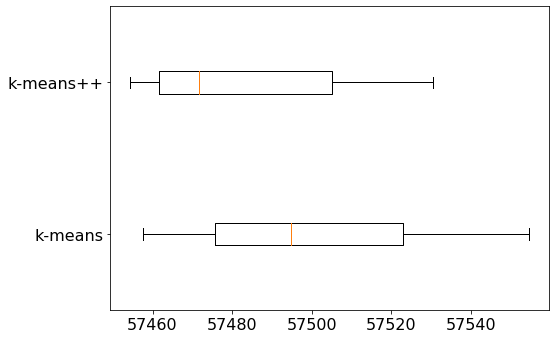

In [38]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* On average, k-means++ produces a better clustering than Random initialization.
* Variation in clustering quality is smaller for k-means++.

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [39]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in xrange(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end"
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K.  For each K, use k-means++ and multiple runs to pick the best solution.  In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.

**IMPORTANT: The code block below will take about 10 minutes to finish**

In order to speed up the computations, we run them with only one random seed, but for better performance, one should use more seeds and compare the results. If you don't mind running the code for approximately one hour, feel free to uncomment the following line of code below:

`seed_list = [0]#, 20000, 40000, 60000, 80000, 100000, 120000]`

Side note: In practice, a good implementation of k-means would utilize parallelism to run multiple runs of k-means at once. For an example, see [scikit-learn's KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

2
10
25
50
100


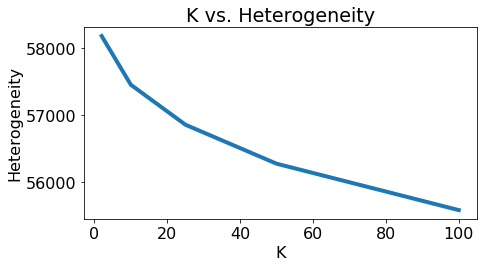

In [40]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print(k)
        sys.stdout.flush()
        '''To save memory space, do not load the arrays from the file right away. We use
           a technique known as lazy evaluation, where some expressions are not evaluated
           until later. Any expression appearing inside a lambda function doesn't get
           evaluated until the function is called.
           Lazy evaluation is extremely important in memory-constrained setting, such as
           an Amazon EC2 t2.micro instance.'''
        centroids[k] = lambda k=k: arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = lambda k=k: arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k](), cluster_assignment[k]())
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [41]:
map_index_to_word = pd.DataFrame(map_index_to_word.items(), columns=['category', 'index'])

In [42]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word['category'][idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

Let us first look at the 2 cluster case (K=2).

In [43]:
visualize_document_clusters(wiki, tf_idf, centroids[2](), cluster_assignment[2](), 2, map_index_to_word)

Cluster 0    
serieslong:0.025
bostonas:0.017
33story:0.012
gan:0.011
efovi:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda               

Both clusters have mixed content, although cluster 1 is much purer than cluster 0:
* Cluster 0: academia, law
* Cluster 1: female figures, baseball players

Roughly speaking, the entire dataset was divided into athletes and non-athletes. It would be better if we sub-divided non-atheletes into more categories. So let us use more clusters. How about `K=10`?

In [44]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)

Cluster 0    
allmvfc:0.020
scientistagreed:0.014
gan:0.011
psihomodo:0.010
2001pasithee:0.010


* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0.97823

anchoragearea:0.076
ssls:0.060
eros1988:0.056
sibinki:0.044
ngandu:0.037


* Todd Curley                                        0.92731
  todd curley born 14 january 1973 is a former australian rules footballer who played for co
  llingwood and the western bulldogs in the australian football league

* Ashley Prescott                                    0.92992
  ashley prescott born 11 september 1972 is a former australian rules footballer he played w
  ith the richmond and fremantle football clubs in the afl between

* Pete Richardson                                    0.93204
  pete richardson born october 17 1946 in youngstown ohio is a former american football defe
  nsive back in the national football league and former college head

* Nathan Brown (Australian footballer born 1976)     0.93561
  nathan daniel brown born 14 august 1976 is an australian rules footballer who played for t
  he melbourne demons in the australian football leaguehe was drafted

* Earl Spalding             

Clusters 0, 1, and 5 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: artists, book, him/his
* Cluster 1: film, theatre, films, tv, actor 
* Cluster 2: baseball players
* Cluster 3: elections, ministers
* Cluster 4: music, orchestra, symphony 
* Cluster 5: female figures from various fields
* Cluster 6: composers, songwriters, singers, music producers
* Cluster 7: law, courts, justice 
* Cluster 8: football 
* Cluster 9: academia

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of baseball players. Increasing the number of clusters may split larger clusters. Another way to look at the size of the clusters is to count the number of articles in each cluster.

In [45]:
cluster_count = np.bincount(cluster_assignment[10]())
print(cluster_count)

# The code below is to answer the following quiz questions

cluster_dict = {'Cluster 0' : cluster_count[0], 'Cluster 4' : cluster_count[3],
                'Cluster 5' : cluster_count[4], 'Cluster 7' : cluster_count[6],
                'Cluster 9' : cluster_count[8]}

greatest_articles = max(cluster_dict)
least_articles = min(cluster_dict)

print('\n\n' + str(cluster_dict))
print('\n' + greatest_articles + ' contains the greatest number of articles')
print('\n' + least_articles + ' contains the least number of articles')

[17602  3415  3535  1736  6445  2552  7106  7155   599  8926]


{'Cluster 0': 17602, 'Cluster 4': 1736, 'Cluster 5': 6445, 'Cluster 7': 7106, 'Cluster 9': 599}

Cluster 9 contains the greatest number of articles

Cluster 0 contains the least number of articles


<font color='steelblue'><b> Quiz 1 : Which of the 10 clusters above contains the greatest number of articles? </b></font>

<font color='slategray'><b>
1. * Cluster 0: artists, book, him/his
2. * Cluster 4: music, orchestra, symphony 
3. * Cluster 5: female figures from various fields
4. * Cluster 7: law, courts, justice 
5. * Cluster 9: academia 
</b></font>

<font color='mediumvioletred'><b> Answer 1 : {{greatest_articles}} contains the greatest number of articles </b></font>

<br/>

<font color='steelblue'><b> Quiz  : Which of the 10 clusters above contains the least number of articles? </b></font>

<font color='slategray'><b>
1. * Cluster 0: artists, book, him/his
2. * Cluster 4: music, orchestra, symphony 
3. * Cluster 5: female figures from various fields
4. * Cluster 7: law, courts, justice 
5. * Cluster 9: academia 
</b></font>

<font color='mediumvioletred'><b> Answer 2 : {{least_articles}} contains the least number of articles </b></font>

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.

In [46]:
visualize_document_clusters(wiki, tf_idf, centroids[25](), cluster_assignment[25](), 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0    
blitzattack:0.077
addie:0.048
recordingstheir:0.046
buntingfrom:0.038
hettingers:0.038

Cluster 1    
preposition:0.054
2210:0.033
hundreaarsvisningen:0.032
efovi:0.031
allenshortly:0.029

Cluster 2    
ibnez:0.216
jeffnominated:0.134
usyd:0.065
sibinki:0.052
19771992according:0.047

Cluster 3    
zahida:0.065
pricepottenger:0.042
newsweekkhan:0.031
trag:0.027
slowburn:0.023

Cluster 4    
incertidumbre:0.025
2012frostad:0.023
hareher:0.022
dumbblonde:0.022
disbandedkirwan:0.020

Cluster 5    
lopilato:0.160
madeamhali:0.056
1200in:0.044
zahida:0.043
pricepottenger:0.042

Cluster 6    
efovi:0.044
2210:0.037
rezas:0.035
wone:0.034
chandanapally:0.031

Cluster 7    
pricepottenger:0.066
cranberries:0.058
movessince:0.051
zahida:0.045
popclub:0.043

Cluster 8    
madeley:0.095
dilber:0.056
qafl:0.054
tray:0.052
arvo:0.051

Cluster 9    
hilger:0.146
repertoryborn:0.096
1982read:0.053
postmodernismlike:0.048
preposition:0.043

Cluster 10    
agency:0.075
substantialhe:0.050


Looking at the representative examples and top words, we classify each cluster as follows.

* Cluster 0: Literature
* Cluster 1: Film and theater
* Cluster 2: Law
* Cluster 3: Politics
* Cluster 4: Classical music
* Cluster 5: Popular music
* Cluster 6: Jazz music
* Cluster 7: Business and economics
* Cluster 8: (mixed; no clear theme)
* Cluster 9: Academia and research
* Cluster 10: International affairs
* Cluster 11: Baseball
* Cluster 12: Art
* Cluster 13: Military
* Cluster 14: Politics
* Cluster 15: Radio and TV
* Cluster 16: Catholic church
* Cluster 17: Opera and ballet
* Cluster 18: Orchestra music
* Cluster 19: Females from various fields
* Cluster 20: Car racing
* Cluster 21: General sports
* Cluster 22: Rugby
* Cluster 23: Rock music
* Cluster 24: Team sports

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [47]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

# The code below is to answer the following quiz question
print('\n\n')
num_of_clusters = np.sum(np.bincount(cluster_assignment[100]()) < 236)
print(num_of_clusters, 'clusters contain the fewer than 236 articles')

Cluster 0    
isolates:0.137
zincavage:0.082
asiabased:0.056
pantherslabowitch:0.053
machairitsas:0.050

Cluster 1    
keimyung:0.170
razed:0.085
pozsgay:0.083
lectrices:0.072
1065ray:0.058

Cluster 2    
proa:0.247
examinationspaulker:0.069
10093:0.056
terribles:0.031
berr:0.029

Cluster 3    
queer:0.181
yearhansen:0.121
rostersleeth:0.042
awardspreviously:0.036
psihomodo:0.034

Cluster 4    
huld:0.309
1999derek:0.220
stagelavin:0.066
kartvelology:0.041
affiliatechoi:0.031

Cluster 5    
franquin:0.192
turhapuro:0.127
wayak:0.054
bruschi:0.046
ebu:0.042

Cluster 6    
hettingers:0.059
addie:0.053
eba:0.051
lohiau:0.049
damepazan:0.044

Cluster 7    
verwaltung:0.105
childrenseveral:0.099
movessince:0.071
pricepottenger:0.067
barns:0.061

Cluster 8    
hilger:0.065
efovi:0.048
preposition:0.045
2210:0.043
repertoryborn:0.043

Cluster 9    
raben:0.086
greno:0.076
prospectsaustin:0.061
qasr:0.053
foreignnational:0.040

Cluster 10    
serieslong:0.188
bostonas:0.052
studentsresearchthr

conder:0.088
1975one:0.044
33story:0.040
gamesjohnson:0.033
ironmanlength:0.027

Cluster 68    
serieslong:0.158
bostonas:0.152
33story:0.020
conder:0.016
foundationweiner:0.013

Cluster 69    
denn:0.194
adhunik:0.034
jspvit:0.031
brance:0.029
meadowhall:0.027

Cluster 70    
deni:0.099
sharewarejunkiescom:0.089
uttam:0.086
preposition:0.039
patras:0.039

Cluster 71    
sammelans:0.145
trag:0.115
zahida:0.053
slowburn:0.049
lohiau:0.048

Cluster 72    
cowardhis:0.459
evidencein:0.087
serieslong:0.082
senghors:0.063
agency:0.062

Cluster 73    
serieslong:0.147
bostonas:0.105
interlingual:0.098
allmvfc:0.063
namadi:0.054

Cluster 74    
serieslong:0.101
bostonas:0.065
studentsresearchthroughout:0.012
bruschi:0.010
2001pasithee:0.009

Cluster 75    
2009genuinely:0.196
lectrices:0.177
probodybuilding:0.099
ostende:0.074
hospitaljane:0.073

Cluster 76    
leaguesanctioned:0.242
litagaylord:0.064
kampi:0.061
lopilato:0.059
outfielderdavanon:0.051

Cluster 77    
allmvfc:0.233
2004urem:0.

The class of team sports has been broken into several clusters, soccer (association football) (11, 22, 24), rugby (76), hockey (80), basketball (86), cricket (87), and American football (85).

The class of baseball has been broken into San Francisco Giants (45), baseball (61, 74), and baseball stats (88).

The class of car racing has been broken into Nascar (20) and Formula 1 (52).

**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Brazil, wrestling, computer science and the Mormon Church. If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much **granularity** we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**

Another heuristic people use that does not rely on so much visualization, which can be hard in many applications (including here!) is as follows.  Track heterogeneity versus K and look for the "elbow" of the curve where the heterogeneity decrease rapidly before this value of K, but then only gradually for larger values of K.  This naturally trades off between trying to minimize heterogeneity, but reduce model complexity.  In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K (which are even harder to visualize using the methods we attempted above.)

<font color='steelblue'><b> Quiz : Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). How many of the 100 clusters have fewer than 236 articles, i.e. 0.4% of the dataset? </b></font>

<font color='mediumvioletred'><b> Answer : {{num_of_clusters}} clusters contain the fewer than 236 articles </b></font>